In [ ]:
https://romg2.github.io/mlguide/10_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-05.-%ED%9A%8C%EA%B7%80-%EC%8B%A4%EC%8A%B5/

In [ ]:
# 고급 회귀 기법

In [ ]:
자전거 대여 수요 예측: https://www.kaggle.com/competitions/bike-sharing-demand/data
주택 가격: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### 데이터 사전 처리(Preprocessing)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
house_df_org  = pd.read_csv('../data/house_price_train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
이 데이터는 가공 작업을 많이 진행할 것이기에 원본과 카피본을 분리해 카피본을 가공한다.

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
house_df.shape

(1460, 81)

In [ ]:
# 데이터는 1,460 x 81개로 이루어져 있으며 종속 변수는 SalePrice로 int형이며 주택 가격을 의미한다.

In [5]:
print('### Feature type ###')
print(house_df.iloc[:,:-1].dtypes.value_counts())

print('\n### Null Feature ###')
isnull_series = house_df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

### Feature type ###
object     43
int64      34
float64     3
Name: count, dtype: int64

### Null Feature ###
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [ ]:
피처 타입은 숫자형, 문자형 고루 존재한다.

결측값이 있는 피처가 제법 있으며 1,000개가 넘는 결측값이 있는 PoolQC, MiscFeature, Alley, Fence는 제거한다.

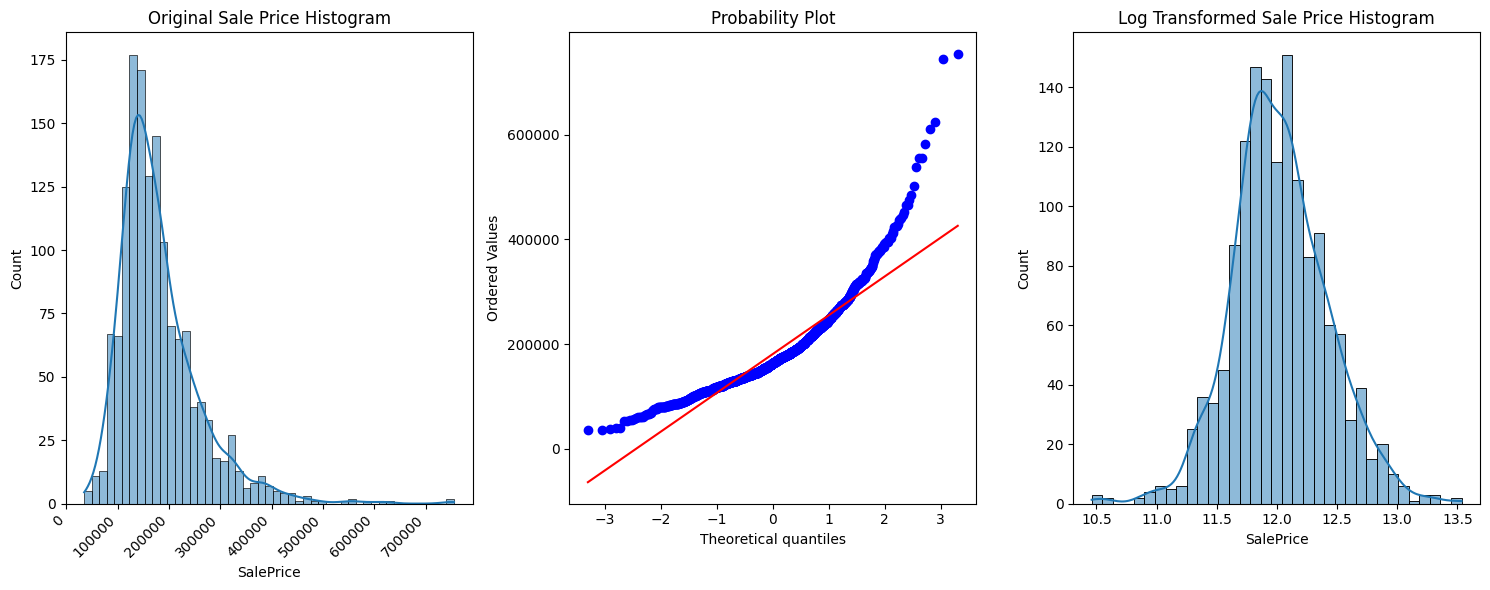

In [6]:
from scipy import stats

# 서브플롯을 1행 3열로 생성, 전체 크기는 15x6 인치로 설정
fig, axs = plt.subplots(1,3, figsize = (15,6))

# 원본 SalePrice 히스토그램을 그리고 커널 밀도 추정 (KDE)를 추
sns.histplot(house_df["SalePrice"], ax =axs[0], kde=True)
# Q-Q 플롯을 생성하여 SalePrice가 정규 분포를 따르는지 시각화
stats.probplot(house_df["SalePrice"], dist='norm', fit=True, plot=axs[1])
# 로그 변환된 SalePrice 히스토그램을 그리고 KDE를 추가
sns.histplot(np.log1p(house_df["SalePrice"]), ax=axs[2], kde=True)

# 각 서브플롯의 제목 설정
axs[0].set_title("Original Sale Price Histogram")
axs[2].set_title("Log Transformed Sale Price Histogram")

# x축 레이블 회전
# for ax in axs:
#     for label in ax.get_xticklabels():
#         label.set_rotation(45)
#         label.set_ha('right')

# x축 레이블을 45도 회전시키고 오른쪽 정렬하여 겹치지 않게 설정
for label in axs[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

# 그래프 간의 여백을 자동으로 조정
plt.tight_layout()
plt.show()

In [ ]:
종속 변수의 분포는 정규분포 형태를 따르지 않고 로그 변환을 적용하였을 때 정규분포 형태를 띄므로 로그 변환하여 진행한다.

In [25]:
# # 블로그 코드
# # 피처 제거
# house_df.drop( ["Id", "PoolQC", "MiscFeature", "Alley", "Fence"], axis=1, inplace=True )

# # 종속 변수 로그 변환
# org_SalePrice = house_df["SalePrice"]
# house_df["SalePrice"] = np.log1p(house_df["SalePrice"])

# # 결측값 대체 - 숫자형
# house_df.fillna(house_df.mean(), inplace=True)

# # 원-핫 인코딩 - 카테고리형
# house_df_ohe = pd.get_dummies(house_df)

TypeError: can only concatenate str (not "int") to str

In [7]:
# 수정된 코드
# # 피처 제거
house_df.drop(["Id", "PoolQC", "MiscFeature", "Alley", "Fence"], axis=1, inplace=True)

# 종속 변수 로그 변환
org_SalePrice = house_df["SalePrice"]
house_df["SalePrice"] = np.log1p(house_df["SalePrice"])

# 결측값 대체 - 숫자형
numeric_cols = house_df.select_dtypes(include=[np.number]).columns
house_df[numeric_cols] = house_df[numeric_cols].fillna(house_df[numeric_cols].mean())

# 결측값 대체 - 문자열형 (빈 문자열로 대체)
categorical_cols = house_df.select_dtypes(include=[object]).columns
house_df[categorical_cols] = house_df[categorical_cols].fillna('')

# 원-핫 인코딩 - 카테고리형
house_df_ohe = pd.get_dummies(house_df)

# 결과 확인
print(house_df_ohe.head())

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0          2003       196.0         706           0  ...           False   
1          1976         0.0         978           0  ...           False   
2          2002       162.0         486           0  ...           False   
3          1970         0.0         216           0  ...           False   
4          2000       350.0         655           0  ...           False   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0         False  

In [ ]:
필요 없는 Id 피처 및 앞서 확인한 결측 1,000건 이상 피처를 제거하였다.

종속 변수는 로그 변환하고 나머지 피처 중 숫자형 피처의 결측값은 평균값으로 대체 하였다.

카테고리형 피처는 원-핫 인코딩을 진행하였고 원-핫 인코딩은 결측값을 None 컬럼으로 대체한다.

pd.get_dummies()는 자동으로 object형만 원-핫 인코딩을 진행한다.

In [8]:
print("원-핫 인코딩 전 shape:", house_df.shape)
print("원-핫 인코딩 후 shape:", house_df_ohe.shape)

원-핫 인코딩 전 shape: (1460, 76)
원-핫 인코딩 후 shape: (1460, 287)


In [ ]:
원-핫 인코딩으로 인해 피처 갯수는 많이 증가하였다.

### 선형 회귀 모델의 학습/예측/평가

#### 기본 예측/평가

##### RMSE함수

In [9]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} 로그 변환된 RMSE: {np.round(rmse, 4)}')

    return rmse

def get_rmses(models):
    rmses = []

    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)

    return rmses

In [ ]:
종속 변수를 로그 변환 하였으므로 RMSE는 원래 스케일에서의 RMSLE이다.

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 예측 평가
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.1321
Ridge 로그 변환된 RMSE: 0.1283
Lasso 로그 변환된 RMSE: 0.1763


In [ ]:
RMSE는 Ridge가 가장 낮게 나왔고 Lasso가 가장 높게 나타났다.

추후 하이퍼 파라미터 튜닝을 진행해서 확인 해보자.

##### 회귀 계수 시각화 함수

In [ ]:
## 아래는 블로그 코드

In [11]:
# 상위, 하위 10개 coefficients 추출
def get_top_bottom_coef(model):
    # coef series
    coef = pd.Series(model.coef_, index = X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

# 회귀 계수 시각화
def visualize_coefficient(models, xlim=None):
    fig, axs = plt.subplots(3,1, figsize=(24,20))
    fig.tight_layout()

    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low], axis=0 )

        axs[i].set_title(model.__class__.__name__ , size=25, x= 0.9, y= 0.1)
        # axs[i].tick_params(axis="y", direction="in", pad=-120) # tick label 위치 조정

        # font size 조정
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)

        # x축 범위
        if xlim:
            axs[i].set_xlim(xlim)

        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i])

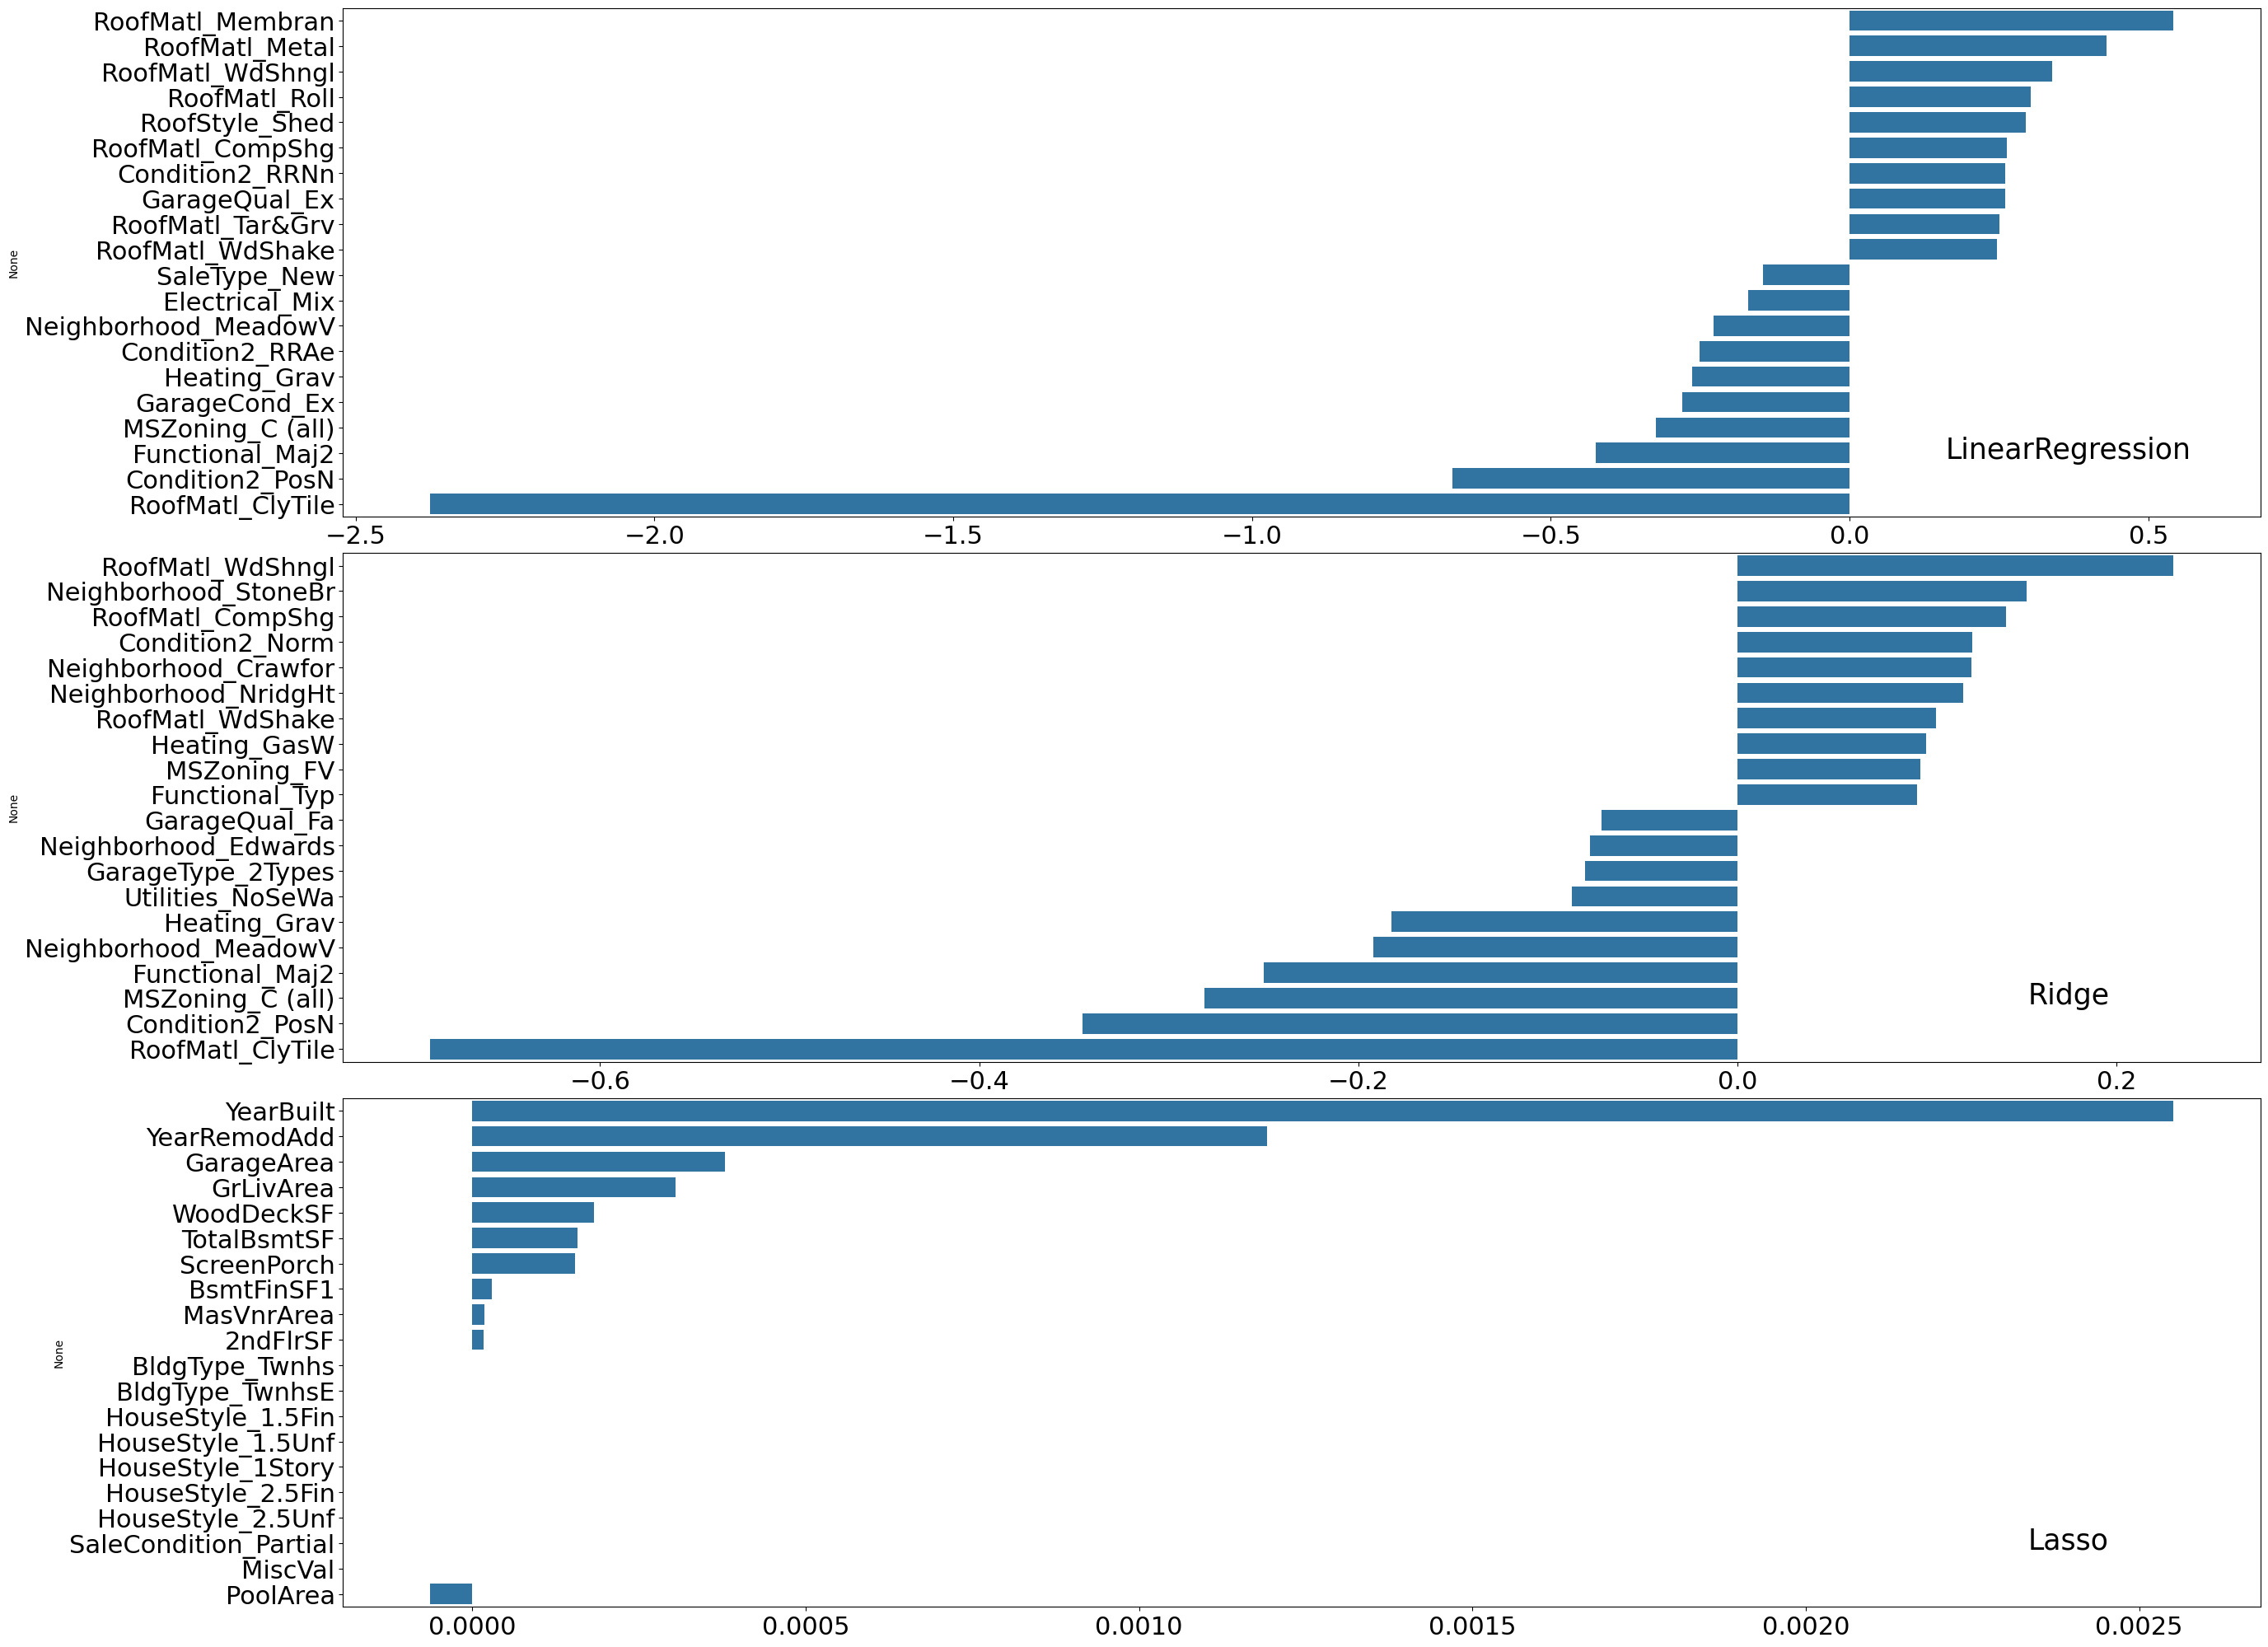

In [12]:
# LinearRegression, Ridge, Lasso
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
각 모델별 상위, 하위 10개 회귀계수를 확인하였을 때 LinearRegression과 Ridge는 피처 종류가 유사하게 나타났다.

반면에 Lasso는 다른 두 모델과 피처 종류도 차이가 있고, x축을 보면 전체적으로 회귀 계수 값이 매우 낮다.

Lasso 성능의 문제가 train, test 분할에 문제가 있는지 교차 검증을 진행하여 평균 RMSE를 확인해보자.

#### 교차검증

##### 교차검증 평균 RMSE 함수

In [13]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        mse_scores = -1*cross_val_score(model, X_features, y_target,
                                        scoring="neg_mean_squared_error", cv=5)
        rmse_scores = np.sqrt(mse_scores)
        rmse_avg = np.mean(rmse_scores)

        print(f"{model.__class__.__name__} CV RMSE 리스트: {np.round(rmse_scores,3)}")
        print(f"{model.__class__.__name__} CV 평균 RMSE: {rmse_avg:.3f}\n")

In [14]:
# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression CV RMSE 리스트: [1.350000e-01 3.594573e+03 1.670000e-01 6.405631e+03 6.155872e+03]
LinearRegression CV 평균 RMSE: 3231.275

Ridge CV RMSE 리스트: [0.118 0.156 0.142 0.117 0.188]
Ridge CV 평균 RMSE: 0.144

Lasso CV RMSE 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE: 0.198



In [ ]:
기본 예측/평가에선 train으로 학습 후 test에 대해 평가하였으나 여기선 전체 데이터로 교차 검증 하였음을 인지하자.

여전히 Lasso 성능은 다른 두 모델에 비해 떨어진다.

이번엔 GridSearchCV를 통해 Ridge와 Lasso의 최적 하이퍼 파라미터를 찾아 적용해보자.

#### GridSearchCV

##### 하이퍼 파라미터 도출 함수

In [15]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    model_name = model.__class__.__name__
    grid_cv = GridSearchCV(model, param_grid=params,
                           scoring='neg_mean_squared_error', cv=5)

    grid_cv.fit(X_features, y_target)
    best_rmse = np.sqrt(-1* grid_cv.best_score_)

    print(f'{model_name} GridSearchCV 최적 평균 RMSE: {np.round(best_rmse, 4)}, 최적 alpha:{grid_cv.best_params_}')

    return grid_cv.best_estimator_

In [16]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1417, 최적 alpha:{'alpha': 12}
Lasso GridSearchCV 최적 평균 RMSE: 0.1419, 최적 alpha:{'alpha': 0.001}


In [ ]:
GridSearchCV를 적용해서 Ridge와 Lasso의 최적 하이퍼 파라미터를 찾았다.

최적 하이퍼 파라미터일 때의 평균 RMSE가 이번엔 Ridge와 Lasso가 유사한 값으로 Lasso의 성능이 향상되었다.

앞서 교차 검증과 비교하면 Ridge 역시 조금이나마 성능이 향상되었다.

LinearRegression 로그 변환된 RMSE: 0.1321
Ridge 로그 변환된 RMSE: 0.1249
Lasso 로그 변환된 RMSE: 0.1208


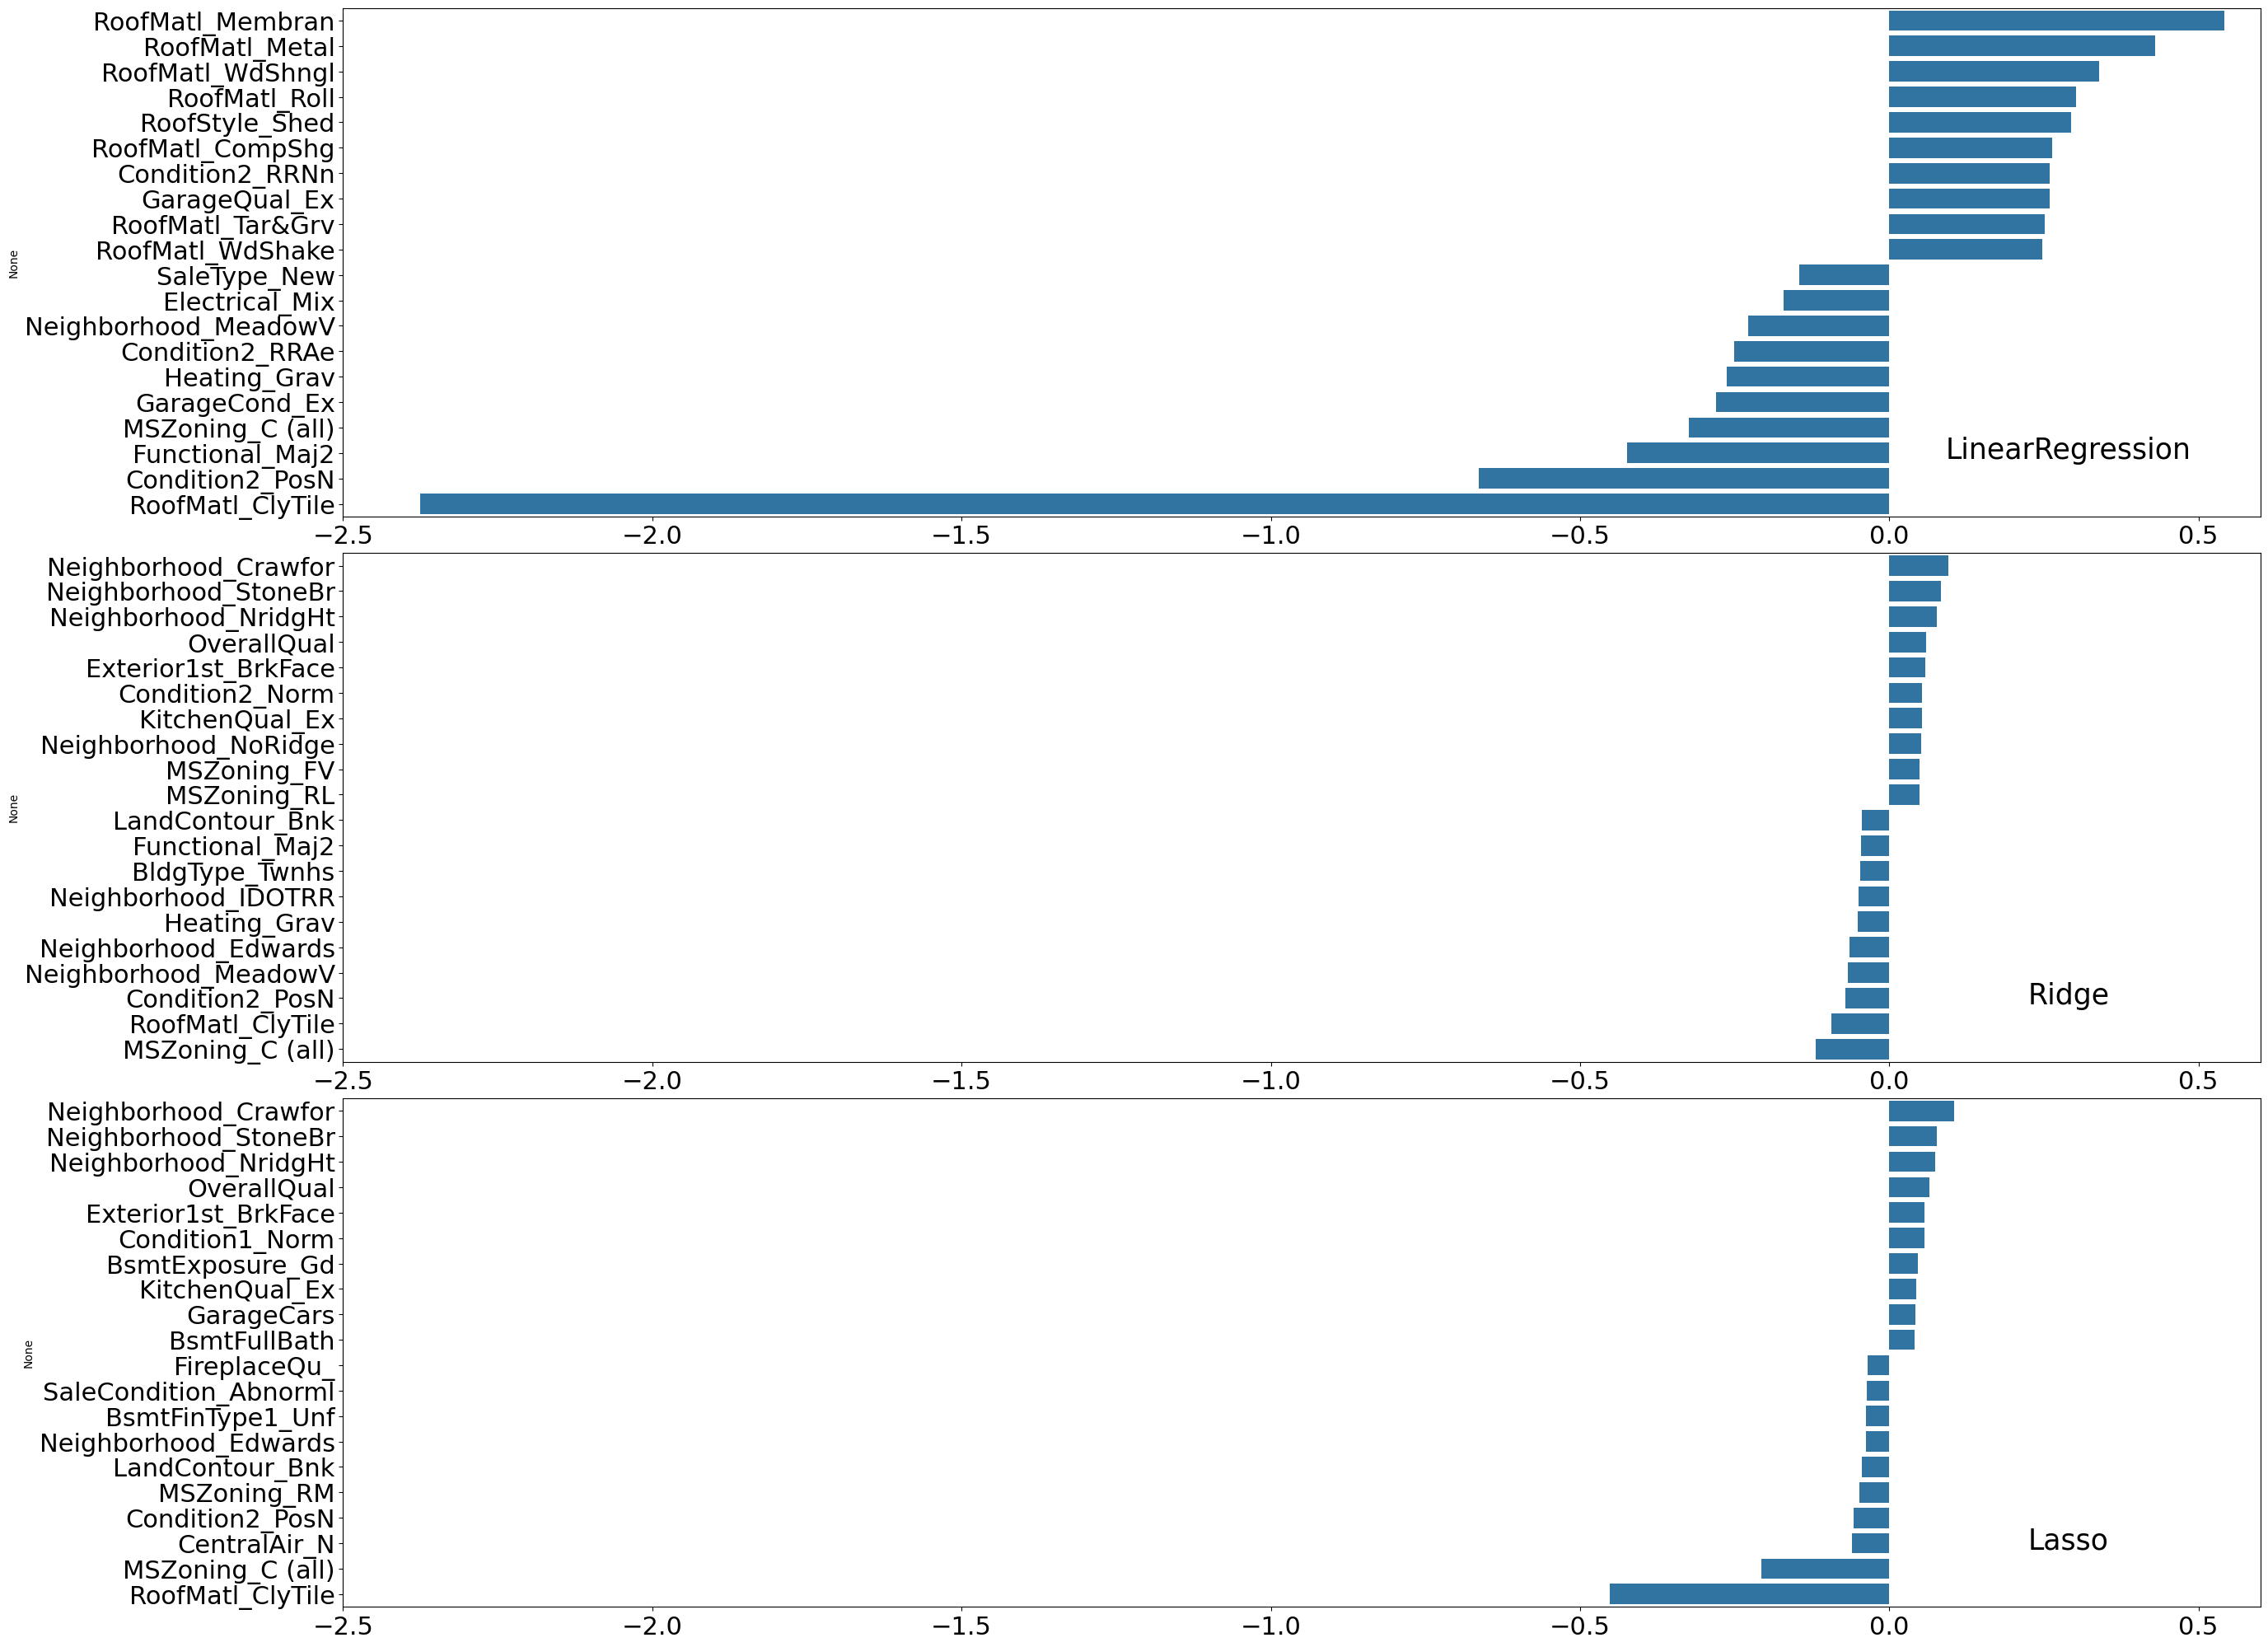

In [17]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=12)
lasso_reg = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models, xlim=(-2.5,0.6))

In [ ]:
최적 하이퍼 파라미터 적용 후 test 예측 성능도 더 좋아졌다.

앞서 Lasso가 상위,하위 피처 종류에 차이가 많았지만 Ridge와 피처 종류도 비슷해졌다.

#### 피처 로그 변환
데이터 왜곡 로그 변환 후 성능 평가

In [ ]:
앞서 종속 변수는 로그 변환을 진행하였는데 이번엔 피처 중 왜곡도가 심한 피처를 로그 변환 해본다.

일반적으로 skew() 함수 반환 값이 1 이상인 경우 왜곡도가 높다고 판단한다고 한다.

In [18]:
from scipy.stats import skew

# 숫자형 피처 컬럼 index
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# 피처(열)별로 왜곡도 산출
skew_features = house_df[features_index].apply(lambda x : skew(x), axis=0)

# 왜곡도가 1 이상
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [ ]:
앞서 사용한 house_df_ohe 데이터는 원-핫 인코딩을 적용하여 카테고리 피처가 숫자형으로 되어있다.

따라서 원-핫 인코딩 적용 전 데이터 house_df로 숫자형 변수의 왜곡도를 확인하였다.

이제 왜곡도 값이 1 이상인 피처에 대해 로그 변환을 적용해보자.

In [19]:
# 피처 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# 원-핫 인코딩
house_df_ohe2 = pd.get_dummies(house_df)

# 데이터 재분리
X_features = house_df_ohe2.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe2['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [20]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1276, 최적 alpha:{'alpha': 12}
Lasso GridSearchCV 최적 평균 RMSE: 0.1254, 최적 alpha:{'alpha': 0.001}


In [ ]:
피처 로그 변환 이후 Ridge와 Lasso의 최적 하이퍼 파라미터를 다시 구하였다.

최적 하이퍼 파라미터는 변화 없었지만 최적 평균 RMSE는 피처 로그 변환 이전에 비해 두 모델 모두 낮아졌다.

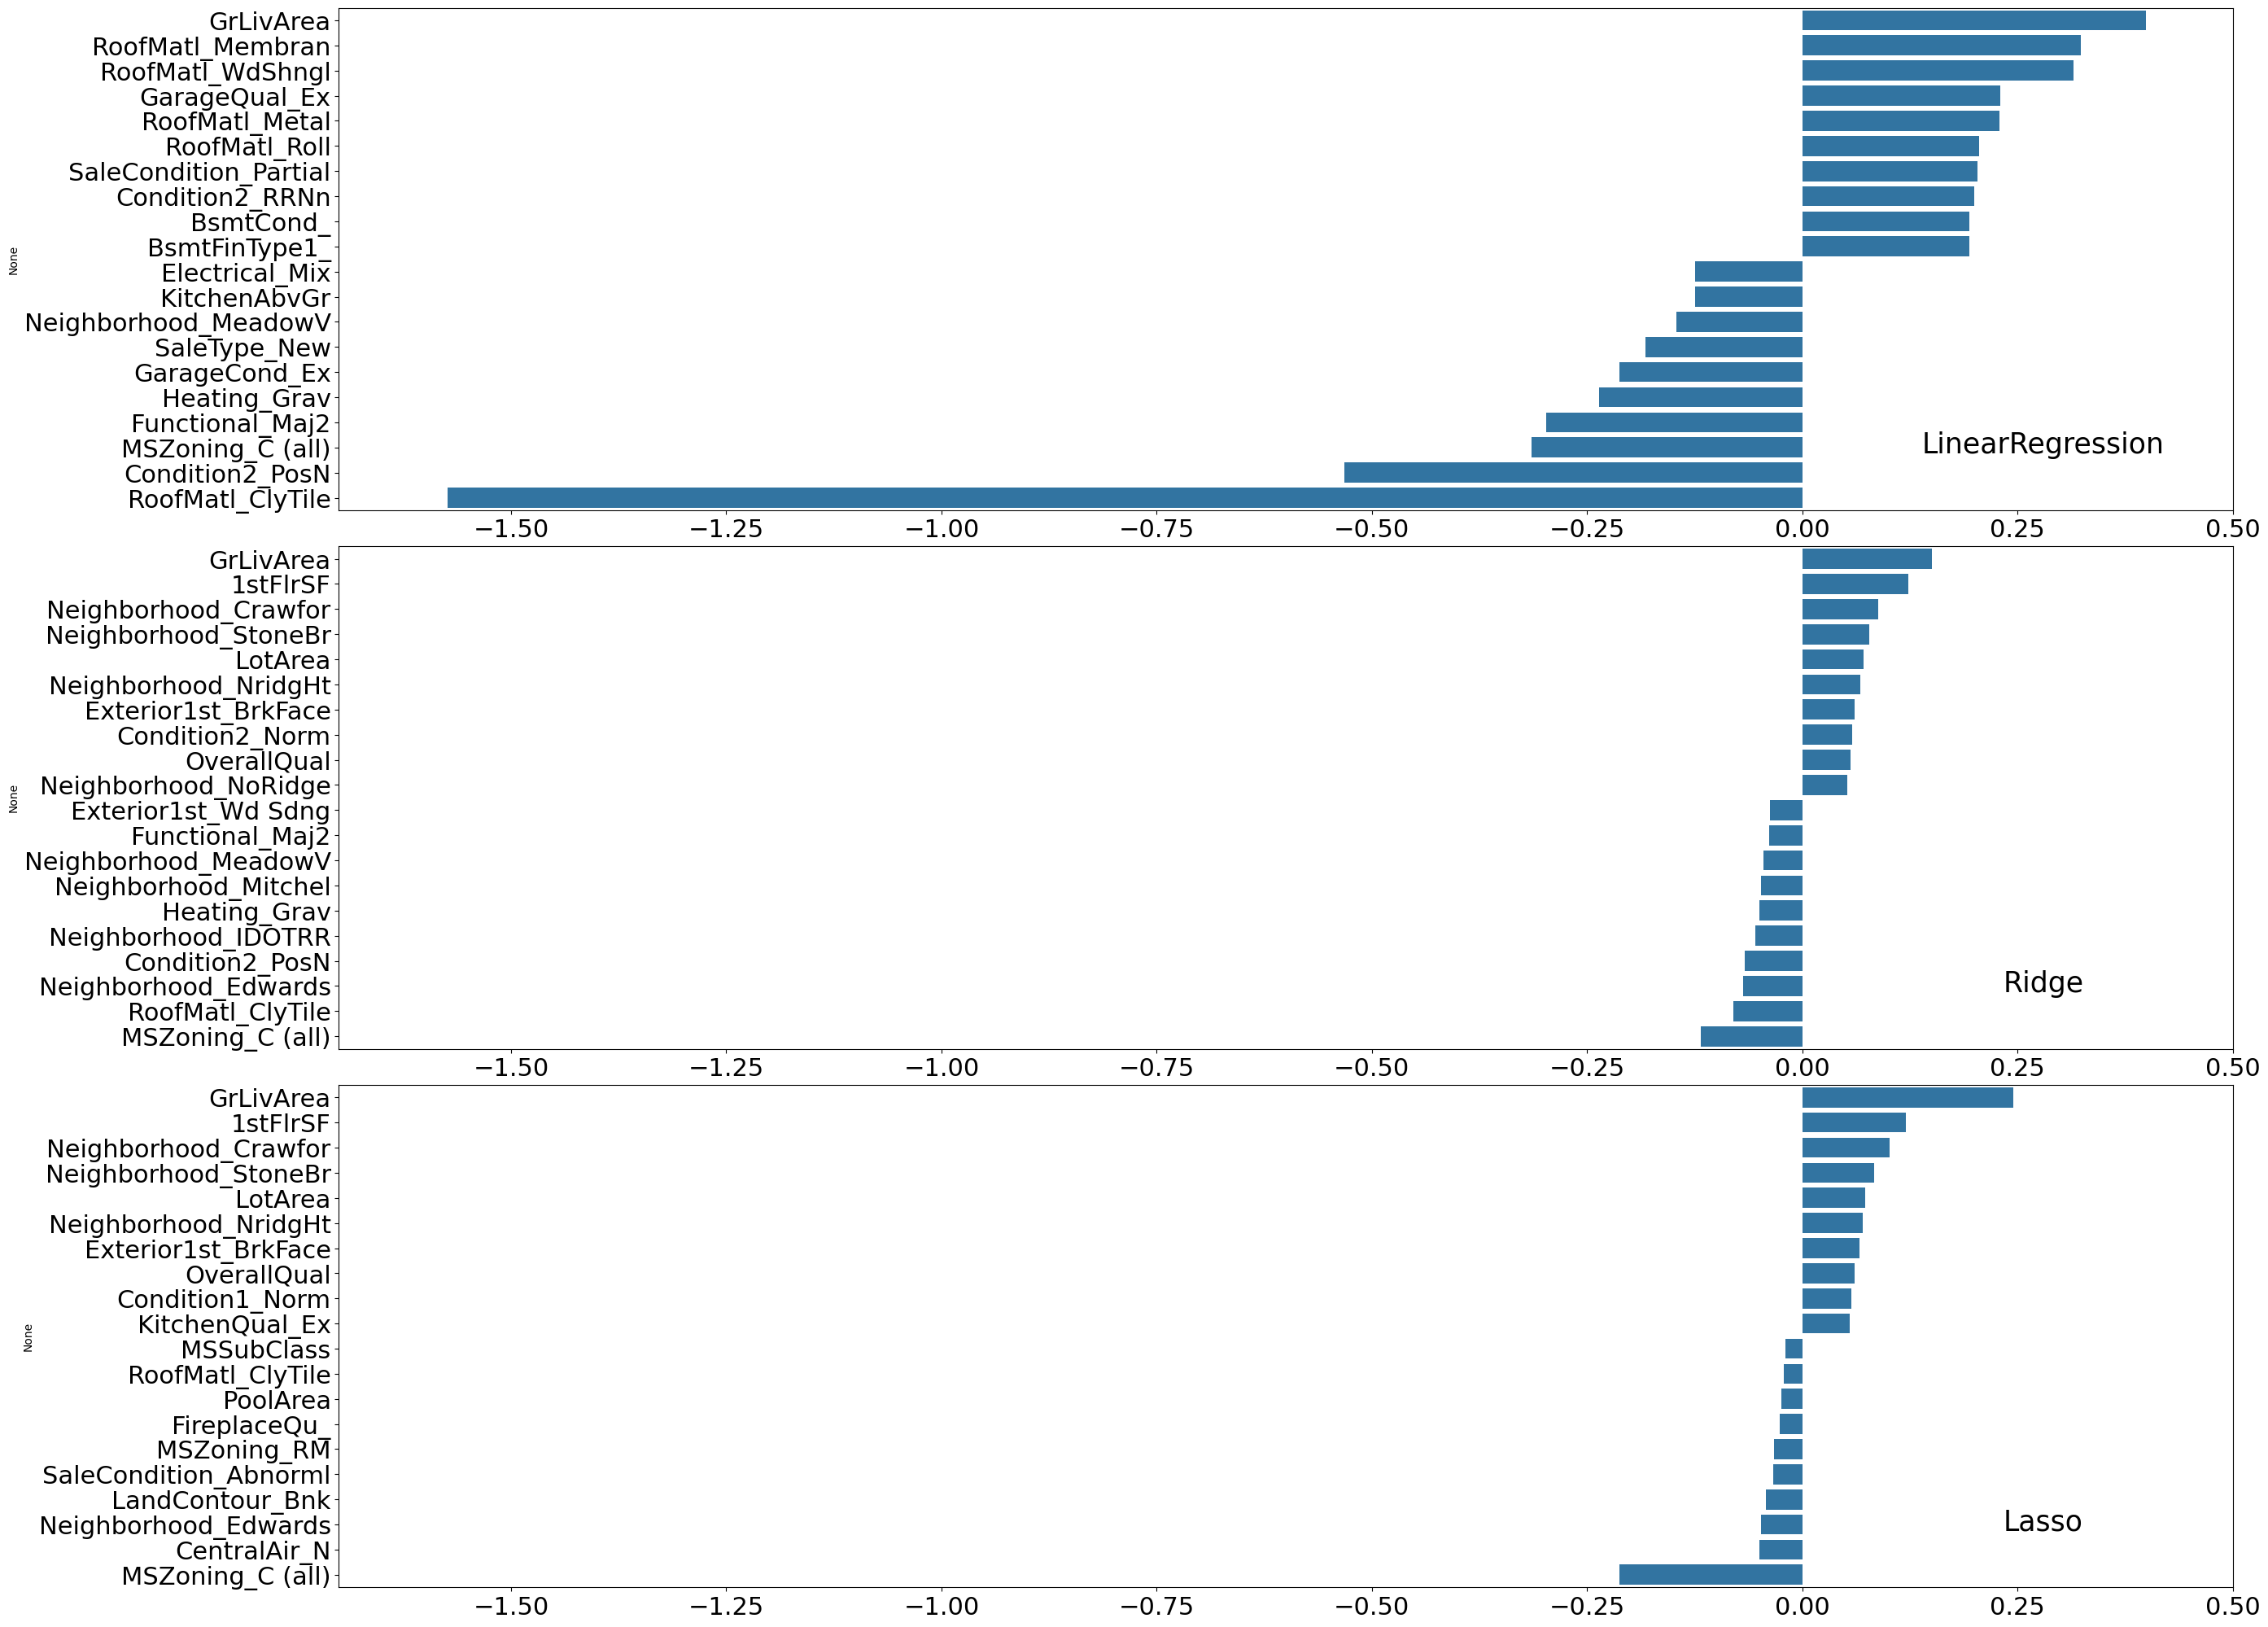

In [21]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=12)
lasso_reg = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models, xlim=(-1.7,0.5))

In [ ]:
피처 로그 변환 이후 각 모델의 회귀 계수를 확인하였을 때 가장 회귀 계수값이 큰 피처는 세 모델 모두 GrLivArea이다.

GrLivArea는 회귀 계수가 가장 커 예측에 많은 영향을 끼치므로 이 피처에 이상치가 있는지 확인 하고 가공해보자.

#### 이상치 제거

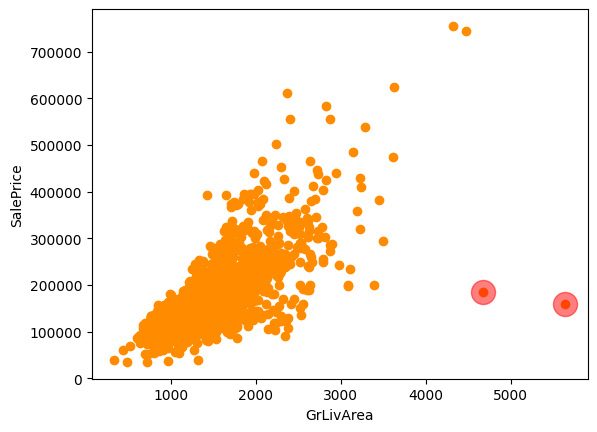

In [22]:
plt.scatter(house_df_org["GrLivArea"] , house_df_org["SalePrice"], c="darkorange")
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

# 추후 확인한 이상치 표시
idx = (house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 200000)
outlier_df = house_df_org[idx]
plt.scatter(outlier_df["GrLivArea"] , outlier_df["SalePrice"], s=300, c="r", alpha=0.5 )

plt.show()

In [ ]:
GrLivArea(주거 공간 평수)와 SalePrice(주택 가격)의 데이터 변환 전 산점도를 그렸다.

일반적으로 생각하는 주거 공간 평수가 클수록 주택 가격이 높아지는 양의 상관관계를 띄는 산점도이다.

다만 4,000평을 넘어가는데 가격이 200,000달러 이하인 경우가 2건 있다.

이상치 기준으로 GrLivArea가 4,000평 이상인데 SalePrice가 500,000달러 이하인 경우 제거하도록 한다.

In [23]:
# GrLivArea, SalePrice 모두 로그 변환 하였으므로 반영한 조건 생성
cond1 = house_df_ohe2['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe2['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe2[cond1 & cond2].index

house_df_ohe3 = house_df_ohe2.drop(outlier_index , axis=0, inplace=False)

print('이상치 삭제 전 house_df_ohe2 shape:', house_df_ohe2.shape)
print('이상치 삭제 후 house_df_ohe3 shape:', house_df_ohe3.shape)

이상치 삭제 전 house_df_ohe2 shape: (1460, 287)
이상치 삭제 후 house_df_ohe3 shape: (1458, 287)


In [ ]:
사실 원본 데이터 house_df_org에서 많은 가공을 했지만 레코드를 삭제한 적은 없으므로 이상치 인덱스를 원본 데이터로 구해도 된다.

앞서 산점도로 확인한 것처럼 2건의 이상치를 제거하였다.

In [24]:
# 데이터 재분리
X_features = house_df_ohe3.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe3['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [25]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1126, 최적 alpha:{'alpha': 8}
Lasso GridSearchCV 최적 평균 RMSE: 0.1123, 최적 alpha:{'alpha': 0.001}


In [ ]:
이상치 제거 이후 Ridge와 Lasso의 최적 평균 RMSE가 감소하였다.

최적 하이퍼 파라미터는 Ridge의 경우 12에서 8로 변하였다.

In [26]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.1283
Ridge 로그 변환된 RMSE: 0.1035
Lasso 로그 변환된 RMSE: 0.1003


In [ ]:
test 예측 성능은 이제까지의 결과 중 세 모델 모두 가장 좋게 나타났다.

### 회귀 트리 학습/예측/평가

In [27]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor GridSearchCV 최적 평균 RMSE: 0.1205, 최적 alpha:{'n_estimators': 1000}


In [28]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3185
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 186
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3195
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 182
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

In [ ]:
작업 수행 시간을 고려해서 하이퍼 파라미터는 한 가지로 설정하였다(즉, 그냥 CV).

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [ ]:
혼합 예측은 만약 A 모델과 B 모델이 있다면 A 모델 예측값의 40%, B 모델 예측값의 60%를 더하여 최종 예측값을 결정한다.

각 모델의 가중치를 정하는 기준은 따로 없으며, 보다 성능이 좋은 모델에 가중치를 더 부여할 수도 있다.

##### 혼합 RMSE함수

In [29]:
def get_rmse_pred(preds):
    for key in preds.keys():
        prediction = preds[key]

        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)

        print(f"{key} 모델 RMSE: {rmse:.4f}")

In [30]:
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 혼합 예측
fusion_pred = 0.4*ridge_pred + 0.6*lasso_pred

# 개별 예측, 혼합 예측 평가
preds = {
    "Ridge": ridge_pred,
    "Lasso": lasso_pred,
    "Fusion": fusion_pred
}

get_rmse_pred(preds)

Ridge 모델 RMSE: 0.1035
Lasso 모델 RMSE: 0.1003
Fusion 모델 RMSE: 0.1001


In [ ]:
혼합 모델의 RMSE가 가장 낮게 나왔으며 어떻게 보면 분류에서 배운 보팅 방식과 비슷한 느낌이다.

### 스태킹 앙상블 회귀

##### CV 스태킹 함수

In [97]:
# # 4장에서 정의한 CV 스태킹 함수
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error

# # 개별 모델별 메타 데이터
# def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds ):
#     # KFold 생성
#     kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)

#     # 메타 데이터 반환을 위한 기본 배열
#     train_cnt = X_train.shape[0]
#     test_cnt = X_test.shape[0]
#     train_meta = np.zeros((train_cnt, 1))
#     test_meta = np.zeros((test_cnt, n_folds))

#     print(model.__class__.__name__ , ' model 시작 ')

#     # train 데이터를 기반으로 fold를 나눠 학습/예측
#     for i , (train_fold_idx, test_fold_index) in enumerate(kf.split(X_train)):
#         # train, test fold 생성
#         print(f'\t 폴드 세트: {i+1} 시작 ')
#         x_train_fold = X_train[train_fold_idx]
#         y_train_fold = y_train[train_fold_idx]
#         x_test_fold = X_train[test_fold_index]

#         # train_fold로 학습
#         model.fit(x_train_fold , y_train_fold)

#         # train 메타 데이터 생성 (x_test_fold 예측)
#         train_meta[test_fold_index, :] = model.predict(x_test_fold).reshape(-1,1)

#         # test 메타 데이터 생성 (x_test 예측) - 평균 전
#         test_meta[:, i] = model.predict(X_test)

#     # test 메타 데이터 생성 - 평균 진행
#     test_meta_mean = np.mean(test_meta, axis=1).reshape(-1,1)

#     # train test 메타 데이터 반환
#     return train_meta , test_meta_mean

In [98]:
# # 데이터 프레임, 시리즈 -> Numpy 배열
# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values

# # 각 모델 학습
# ridge_reg = Ridge(alpha=8)
# lasso_reg = Lasso(alpha=0.001)
# xgb_reg = XGBRegressor(n_estimators= 1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
# lgbm_reg = LGBMRegressor(n_estimators= 1000, learning_rate=0.05, num_leaves=4,
#                          subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

# # 각 모델 메타 데이터
# ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train, y_train, X_test, 5)
# lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train, y_train, X_test, 5)
# xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train, y_train, X_test, 5)
# lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train, y_train, X_test, 5)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [31]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd

# 데이터 프레임, 시리즈 -> Numpy 배열 변환
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# 개별 모델별 메타 데이터 생성 함수
def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)

    train_cnt = X_train.shape[0]
    test_cnt = X_test.shape[0]
    train_meta = np.zeros((train_cnt, 1))
    test_meta = np.zeros((test_cnt, n_folds))

    print(f'{model.__class__.__name__} model 시작')

    for i, (train_fold_idx, test_fold_idx) in enumerate(kf.split(X_train)):
        print(f'\t폴드 세트: {i+1} 시작')
        x_train_fold = X_train[train_fold_idx]
        y_train_fold = y_train[train_fold_idx]
        x_test_fold = X_train[test_fold_idx]

        model.fit(x_train_fold, y_train_fold)

        train_meta[test_fold_idx, :] = model.predict(x_test_fold).reshape(-1, 1)

        test_meta[:, i] = model.predict(X_test)

    test_meta_mean = np.mean(test_meta, axis=1).reshape(-1, 1)

    return train_meta, test_meta_mean

# 각 모델 학습
ridge_reg = Ridge(alpha=8)
lasso_reg = Lasso(alpha=0.001)
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

# 각 모델 메타 데이터 생성
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train, y_train, X_test, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train, y_train, X_test, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train, y_train, X_test, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train, y_train, X_test, 5)

# 결과 확인
print(ridge_train.shape, ridge_test.shape)
print(lasso_train.shape, lasso_test.shape)
print(xgb_train.shape, xgb_test.shape)
print(lgbm_train.shape, lgbm_test.shape)


Ridge model 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
Lasso model 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
XGBRegressor model 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
LGBMRegressor model 시작
	폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 175
[LightGBM] [Info] Start training from score 12.021282
	폴드 세트: 2 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data point

In [ ]:
4개의 모델에 대해 train, test 메타 데이터를 생성하였다.

In [32]:
# 최종 메타 데이터 결합
final_X_train_meta = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
final_X_test_meta = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델 학습/예측/평가
meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(final_X_train_meta, y_train)
meta_predict = meta_model_lasso.predict(final_X_test_meta)
rmse = np.sqrt( mean_squared_error(y_test, meta_predict))

print(f"스태킹 회귀 모델 RMSE: {rmse:.4f}")

스태킹 회귀 모델 RMSE: 0.0978


In [ ]:
스태킹 회귀 모델의 RMSE가 0.0975로 현재까지 결과 중 가장 좋은 성능이다.

In [ ]:
흠... 블로그랑 자꾸 글이 다르네 ㅋㅋ